# NLP Topic Modeling in Python with Non-negative Matrix Factorization 

# Preface - Installing Packages 

## Using Jupyter Notebooks 

Jupyter Notebooks is an interactive Python environment for data science.   Cells are seperated into Markdown (i.e., text) and code cells.  In this notebook, you should not need to edit code (unless you really want to!). Therefore, you can just run each cell by highlighting it and pressing "Cmd + Return" or using the "> Run" key at the top.

Note: A best practice is to import packages in the first cell of the notebook.  However, given that this is a tutorial I will import them in the first cell in which they are used to more closely associate the package with it's use.  

## Installing Packages 
First, we'll install some packages we'll use today for our text manipulation and topic modeling. This may produce a lot of output so please be patient. 

In [1]:
# Install libraries if not present. 
!pip install nltk
!pip install squarify

# Import libraries into our environment. 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ssanders/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ssanders/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ssanders/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Import our Data

We're going to use pandas to import and inspect our data.  Notice that our text column is already in lower case and contains the article text from wikipedia.  This is not typically the case in real world data but it saves us some time effort in pre-processing. 

In [2]:
# Import data 
import pandas as pd 

filename = 'people_wiki.csv'
df = pd.read_csv(filename)

#Inspect our dataframe
df.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


## 2. Pre-process our Text 

Before we analyze text we need to clean it.  Cleaning text involves standardizing and removing terms that are non-informative.  Terms that occur in most documents or, alternatively, very few, are unlikely to help us know how to group things. 

In [3]:
import re
import string
from nltk.tokenize.regexp import WordPunctTokenizer
from nltk.corpus import stopwords


# These lines determines what the punctuation and numbers are replaced with.
punct_table = str.maketrans({ch: ' ' for ch in string.punctuation})  
digit_table = str.maketrans('', '', string.digits)

# Text cleaning functions
remove_punctuation = lambda x: x.translate(punct_table)
remove_numbers = lambda x: x.translate(digit_table)
remove_urls = lambda x: re.sub(r"http\S+", "", x)


#Tokenize texts.  Note- It is possible to comment out steps with a # to change how tokenization occurs. 
def tokenize(text):
    """
    Takes a list of strings and return 
         
    """
    # Creates stopword list from NLTK.
    sw = stopwords.words("english") + ['']
      
    # Text cleaning. 
    text = remove_urls(text) # removes urls 
    text = remove_punctuation(text)
    text = remove_numbers(text) # removes numbers.  Leaving here as dates may be informative. 
    text = text.lower() # sets to lowercase
    
    # Tokenization 
    tokenizer = WordPunctTokenizer()
    tkns = tokenizer.tokenize(text) # tokenizes text

    # Remove stopwords 
    tokenized_text = [tkn for tkn in tkns if tkn not in sw]

    return tokenized_text 

Let's see a demonstration of what the above function is doing! 

In [4]:
text = "I moved to Kansas City in 2020 during the pandemic!  It was hard to find housing " \
       "with social distancing but I was eventually able to find one on Zillow (http://www.zillow.com)."

tokenize(text)

['moved',
 'kansas',
 'city',
 'pandemic',
 'hard',
 'find',
 'housing',
 'social',
 'distancing',
 'eventually',
 'able',
 'find',
 'one',
 'zillow']

### Splitting Data 

We're not going to try to optimize the fit of the model in this tutorial but I do want to demonstrate how you can fit unseen data to the model.  Therefore, we're still going to do a test train split.   

In [5]:
from sklearn.model_selection import train_test_split

# Split our data. 
df_train, df_test = train_test_split(df, test_size = 0.1)

### Feature Extraction (Vectorization) 

Computers only undestand numbers we need to convert the tokenized documents into vectors.  To do this we'll use term frequency - inverse docuemnt frequency (TF-IDF) metric. 

Note that we only fit_transform our training data, not our unseen test data.  This helps prevent data leakage.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Intialize vectorizer and transform/vectorize the corpus. Note we override the tokenizer with our custom one. 
vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=.95, min_df=.001, ngram_range=(1,2))
doc_term_matrix = vectorizer.fit_transform(list(df_train['text']))

print("Our matrix has {} documents and {} vocabulary terms.".format(doc_term_matrix.shape[0], 
                                                                    doc_term_matrix.shape[1]))

# Store our vocab for later use. 
model_features = vectorizer.get_feature_names_out()

print("Note that our model features list has the same length as the vocabulary (i.e, they are the same.): {} \n".format(len(model_features)))
print("Sample Feature Names: ", model_features[100:110], '\n')
print("A document is represented like this: \n", doc_term_matrix[0,:])

Our matrix has 38507 documents and 20441 vocabulary terms.
Note that our model features list has the same length as the vocabulary (i.e, they are the same.): 20441 

Sample Feature Names:  ['account' 'accountability' 'accountant' 'accountants' 'accounting'
 'accounts' 'accreditation' 'accredited' 'accumulated' 'accuracy'] 

A document is represented like this: 
   (0, 8356)	0.09481925397071121
  (0, 1558)	0.06198426833622959
  (0, 19029)	0.0861608381734702
  (0, 2305)	0.1008713893399211
  (0, 4503)	0.1041005783930604
  (0, 16850)	0.09994756646209801
  (0, 15553)	0.07782898002149334
  (0, 6574)	0.07839699852808123
  (0, 5745)	0.08279570764086382
  (0, 9674)	0.10537679320619973
  (0, 14443)	0.0904449126912543
  (0, 19081)	0.09481925397071121
  (0, 5678)	0.09112018790917999
  (0, 19902)	0.09592912974146046
  (0, 12798)	0.10135835648556218
  (0, 19108)	0.09750625880731473
  (0, 2945)	0.09788347025060268
  (0, 8365)	0.10504615614279643
  (0, 14106)	0.10293548555141645
  (0, 15150)	0.0939360

# 3.  Model Creation:  Non-Negative Matrix Factorization (NMF)

Shout out to Hui for teaching me that this could be used for topic modeling!  We are going to keep things very simple but I want to provide just a superficial explanation of the logic of this technique.  

Non-negative matrix factorization (NMF) seems like an intimidating technique but the basic logic is very simple. You may remember from elementary school that factorization is breaking a number down into numbers that when multiplied together equal the initial value (e.g., 30 = (2X3)X5 ).  We can do something similiar with matrices.  However, matrix multiplication has a special requirement that the number of rows in one matrix (we'll call is matrix W) must equal the number of columns in the other matrix (matrix H).  Because there are many different values that the number of rows/number of columns can take on we have to select a value for factorization.  Matrix multiplication follows slighty different rules from traditional multiplication which you can read about here.    

Just like we can multiply a simple factorization back together to get the original value (e.g., (2x3)x5 = 30), we can multiply Matrix W X Matrix H to reconstruct our original Document X Term matrix.  However, our reconstructed matrix is unlikely to exactly match our original matrix and the degree to which the values differ tells us how well our proposed model fits.  

One last thing!  *Non-negative Matrix Factorization is exactly that - non-negative*.  No value in the matrix can be below zero.  This makes it a good fit for behavioral data (you can't have negative clicks) but a poor fit for things like financial data where there may be negative values.  

In [7]:
%%time
# Enter the number of topics to model. 
num_topics = 100

from sklearn.decomposition import NMF

# Initialize model
model = NMF(init='nndsvda', n_components=num_topics)

# Fit our corpus to the model 
model.fit(doc_term_matrix)

CPU times: user 5min 58s, sys: 7.87 s, total: 6min 5s
Wall time: 2min 6s


NMF(init='nndsvda', n_components=100)

# 4.  Model Inspection 

### Retrieve Top Terms for each Topic

Here we are retrieving the topic terms that most characterize each topic.  Note that all terms are scored for each topic but we are interested in terms that are most unique and typical for a given a topic.   Generally we inspect the top N terms to get an idea about what the topic is.  I've provided an easy way for you to vary the number of terms returned below. 

In [18]:
#How many terms to do you want to retrieve? 
n_terms = 10

def get_nmf_topics(model, n_top_words, num_topics, feat_names):
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words;
    
    return pd.DataFrame(word_dict)

nmf_topics = get_nmf_topics(model, n_terms, model.n_components, model_features)
nmf_topics

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,...,Topic # 90,Topic # 91,Topic # 92,Topic # 93,Topic # 94,Topic # 95,Topic # 96,Topic # 97,Topic # 98,Topic # 99
0,years,league,billboard,party,role,league,music,art,olympic,district,...,boxing,research,records,jewish,texas,education,piano,album,election,season
1,one,club,chart,parliament,appeared,baseball,composer,museum,olympics,judge,...,title,institute,label,israel,austin,higher education,international,released,manitoba,games
2,work,town,singles,election,actor,major league,musical,gallery,medal,district court,...,champion,science,record,rabbi,university texas,educational,competition,debut album,liberal,signed
3,time,football,single,leader,actress,major,composition,artist,gold,court,...,world,professor,dj,israeli,houston,higher,prize,debut,provincial,end
4,would,goals,number,elected,roles,pitcher,composed,arts,games,attorney,...,fight,scientific,hip,hebrew,dallas,college,festival,songs,conservative,end season
5,family,manager,top,elections,starred,league baseball,composers,work,summer,states district,...,round,sciences,released,jerusalem,american,schools,pianist,release,assembly,first
6,first,side,albums,candidate,played,era,ensemble,exhibition,summer olympics,private practice,...,boxer,biology,hop,jews,texas austin,teacher,chamber,solo,riding,seasons
7,many,appearances,hit,labour,film,minor,classical,painting,silver,federal,...,decision,society,hip hop,palestinian,san antonio,development,performed,albums,progressive,following season
8,people,footballer,million,politician,acting,innings,sound,contemporary,bronze,practice,...,knockout,dr,artists,tel,antonio,community,concerto,single,candidate,following
9,later,scored,country,democratic,drama,pitched,electronic,paintings,world,private,...,world champion,molecular,producer,aviv,houston texas,students,violin,second album,legislative,contract


### Inspecting Representative Documents

We typically want to be able to inspect the original data.  Above when we fit the model, we saved weights that each component characterizes a document.  We're going to select the component with the max value for each document and assign it to that topic.  Then we'll filter our dataframe by topic to see if our topic modeling worked! 

In [9]:
# Get document weights for each component. 
doc_weights = model.transform(doc_term_matrix)

print("Note that the document weights matrix has the name number of rows as documents: {}".format(doc_weights.shape[0]))
print("Additionally observe that is the same number of columns as our topics: {}".format(doc_weights.shape[1]))

Note that the document weights matrix has the name number of rows as documents: 38507
Additionally observe that is the same number of columns as our topics: 100


Now let's print some bios to inspect! Do they make sense to you?  What themes do they have? 

In [12]:
# Which topics documents do you want to inspect? 
topic_id =3

# Reformating topic number 
topic_col = 'Topic # ' + '{:02d}'.format(topic_id)

# Get topic terms 
print("These words characterize this topic: ", "\n")
print(nmf_topics[topic_col], "\n\n")

# Assign topics to biographies in the Dataframe
df_train["Topic_idx"] = doc_weights.argmax(axis=1)

# Filtering our dataframe. 
df_topic = df_train.loc[df_train['Topic_idx'] == topic_id] 
bios = zip(df_topic['name'], df_topic['text'])

# Displaying the selected bios. 
print("Here are the biographies for individuals who scored highly on this topic: ", '\n')

for bio in bios:
    print("Name: ", bio[0])
    print("Biography: ", bio[1], "\n\n")
    

These words characterize this topic:  

0         party
1    parliament
2      election
3        leader
4       elected
5     elections
6     candidate
7        labour
8    politician
9    democratic
Name: Topic # 03, dtype: object 


Here are the biographies for individuals who scored highly on this topic:  

Name:  Abd%C3%BCllatif %C5%9Eener
Biography:  abdllatif ener born 1954 is a former finance minister in the 54th cabinet of the turkish government and served as the deputy prime minister in the 58th and 59th cabinets of recep tayyip erdoanener was born in grn sivas province in turkey he graduated from the school of political sciences at ankara university he earned his phd degree from gazi university in ankara he lectured on finance at gazi university and hacettepe university before he served as a controller in the department of revenues within the ministry of financeener entered politics and was elected 1991 deputy of sivas province from the islamist welfare party rp following the

# 5.  Categorizing Unseen Data 

Now we'll categorize some unseen data.  Note that we only call transform - both for the vectorizer and for the NMF model. This is because we've already fit the training data and we want to transform it with respect to the learned model from the training set. 

In [13]:
# Note that we call transform not fit_transform.
doc_term_matrix_test = vectorizer.transform(list(df_test['text']))

# Predicting topic for unseen data. 
test_nmf_transformed = model.transform(doc_term_matrix_test)
predicted_topic = test_nmf_transformed.argmax(axis=1)

# Join to df_test
df_test['Topic_idx'] = predicted_topic

In [14]:
topic_id = 92

# Filtering our dataframe. 
df_topic = df_test.loc[df_test['Topic_idx'] == topic_id] 
bios = zip(df_topic['name'], df_topic['text'])

# Displaying the selected bios. 
print("Here are the biographies for individuals who scored highly on this topic: ", '\n')

for bio in bios:
    print("Name: ", bio[0])
    print("Biography: ", bio[1], "\n\n")
    

Here are the biographies for individuals who scored highly on this topic:  

Name:  Noel Hogan
Biography:  noel anthony hogan born 25 december 1971 moyross limerick ireland is the current guitarist and working cosongwriter on some of the recent tracks with the cranberrieswith the cranberries on hiatus from 20032009 hogan turned to focus on his own music he began working with programmer matt vaughan who had already done work on unreleased cranberries songs and dolores oriordans solo material mono band was born with noel as the sole band member with vocals being supplied by richard walters alexandra hamnede kate havnevik and other guest artists noel worked with cranberries veteran producer stephen street to compile a mix of twelve tracks working on his side project at the same time saw their resulting debut album mono band released on 20 may 2005hogan and mono band vocalist richard walters went on to form arkitekt arkitekt released two eps at that time in 2009 working on new materialhoga

# 6. Visualization of Results 

There are many ways to segment and visualize the outputs of results.  Here we use a treemap to give us an idea of the prevalence of specific topics in the dataset. 

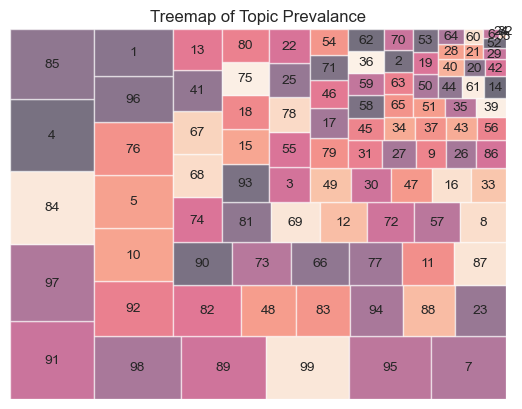

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

sns.set_style(style="whitegrid") # set seaborn plot style
sizes= df_train['Topic_idx'].value_counts()
label= sizes.index
squarify.plot(sizes=sizes, label=label, alpha=0.6).set(title='Treemap of Topic Prevalance')
plt.axis('off')
plt.show()

# 6. Conclusion

Hopefully you found the tutorial above interesting!  If you want to learn more about cleaning and preprocessing text as well as a different technique for topic modeling [check out the Evolytics blog series here](https://github.com/team-evolytics/text_mining_blog).   

For different implemented methods for topic modeling check out 
- [Truncated SVD (Latent Semantic Analysis (LSA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [Latent Dirichlet Allocation (LDA)](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html) 

Please feel free to use the above code for your own projects.  


# Appendix I - Model taking too long to train? 

Having trouble getting the model to run in the time allotted for the tutorial? Fortunately, Python has a module "pickle" that allows for the storage of objects.  I've written a version of the model featured in this notebook to file that you can read it in to finish our exercise. 

**NOTE:** You must run all cells up to step 3 (i.e., fitting the model) for this to run properly.  

In [ ]:
import pickle
import os

files = [
'nmf_model.pkl', 
'doc_term_matrix.pkl', 
'model_features.pkl', 
'vectorizer.pkl', 
'df_train.pkl',
'df_test.pkl'
]

# Set file path. 
path = os.getcwd()+"/saved_model/"

model_data = {}

# Read in pickle file. 
for f in files: 
    with open(path+f, 'rb') as file:
        model_data[f] = pickle.load(file)

# Assign objects 
df_train = model_data['df_train.pkl']  
df_test = model_data['df_test.pkl']
vectorizer = model_data['vectorizer.pkl']
model_features = model_data['model_features.pkl'] 
doc_term_matrix = model_data['doc_term_matrix.pkl']
model = model_data['nmf_model.pkl']   


# Appendix II - Want to save your model? 

Have you tweaked the above script and want to save your own model to file? Run the cell below. 

In [ ]:
import pickle 
import os 

# Specify objects to save to file.
files = {
'nmf_model.pkl': model, 
'doc_term_matrix.pkl': doc_term_matrix, 
'model_features.pkl': model_features, 
'vectorizer.pkl': vectorizer, 
'df_train.pkl': df_train,
'df_test.pkl': df_test
}

# Set file path. 
path = os.getcwd()+"/saved_model/"

# Write objects to file. 
for k,v in files.items(): 
    with open(path+k, 'wb') as file:
        pickle.dump(v, file)
        
df_train.to_csv('df_train.csv') 
df_test.to_csv('df_test.csv')
